In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [10]:
df = pd.read_csv('data/final_dataset.csv', parse_dates=['order_purchase_timestamp'])
df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_item_price,customer_id,order_purchase_timestamp,customer_state,product_category_name_english
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,72.19,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,RJ,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,259.83,f6dd3ec061db4e3987629fe6b26e5cce,2017-04-26 10:53:06,SP,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,216.87,6489ae5e4333f3693df5ad4372dab6d3,2018-01-14 14:33:31,MG,furniture_decor
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,25.78,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:00:35,SP,perfumery
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,218.04,58dbd0b2d70206bf40e62cd34e84d795,2017-02-04 13:57:51,SP,garden_tools


In [12]:
df.dtypes

order_id                                 object
order_item_id                             int64
product_id                               object
seller_id                                object
shipping_limit_date                      object
price                                   float64
freight_value                           float64
total_item_price                        float64
customer_id                              object
order_purchase_timestamp         datetime64[ns]
customer_state                           object
product_category_name_english            object
dtype: object

# Customer Purchase Frequency

In [5]:
customer_orders.head()
customer_orders['num_orders'].describe()
customer_orders['num_orders'].value_counts().head(10)

num_orders
1    98199
Name: count, dtype: int64

Purchase frequency analysis shows that nearly all customers
placed only one order in the dataset.
This indicates limited repeat purchase visibility at the customer_id level.

# RFM Feature Engineering

In [14]:
# Define the reference data
# Latest purchase date + 1 day as reference
reference_date = df['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

rfm = df.groupby('customer_id').agg({
    'order_purchase_timestamp': lambda x: (reference_date - pd.to_datetime(x).max()).days,
    'order_id': 'nunique',
    'total_item_price': 'sum'
}).reset_index()

rfm.rename(columns={
    'order_purchase_timestamp':'Recency',
    'order_id':'Frequency',
    'total_item_price':'Monetary'
}, inplace=True)

# RFM Scoring

In [17]:
# Recency (reverse scoring: lower recency = better)
rfm['R_Score'] = pd.qcut(
    rfm['Recency'],
    5,
    labels=[5,4,3,2,1]
)

# Frequency
rfm['F_Score'] = pd.qcut(
    rfm['Frequency'].rank(method='first'),
    5,
    labels=[1,2,3,4,5]
)

# Monetary
rfm['M_Score'] = pd.qcut(
    rfm['Monetary'],
    5,
    labels=[1,2,3,4,5]
)

# Combine scores
rfm['RFM_Score'] = (
    rfm['R_Score'].astype(str) +
    rfm['F_Score'].astype(str) +
    rfm['M_Score'].astype(str)
)


RFM scores were calculated using quintile-based segmentation.
Recency was reverse scored (lower recency = higher score),
while Frequency and Monetary were scored in ascending order.

# Segmenting the Customers

In [20]:
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

In [23]:
def segment_customer(row):
    
    if row['R_Score'] >= 4 and row['F_Score'] >= 4:
        return 'Champion'
    
    elif row['F_Score'] >= 4:
        return 'Loyal'
    
    elif row['R_Score'] <= 2:
        return 'At Risk'
    
    elif row['M_Score'] >= 4:
        return 'Big Spender'
    
    else:
        return 'Others'

# Visualizing RFM Segments

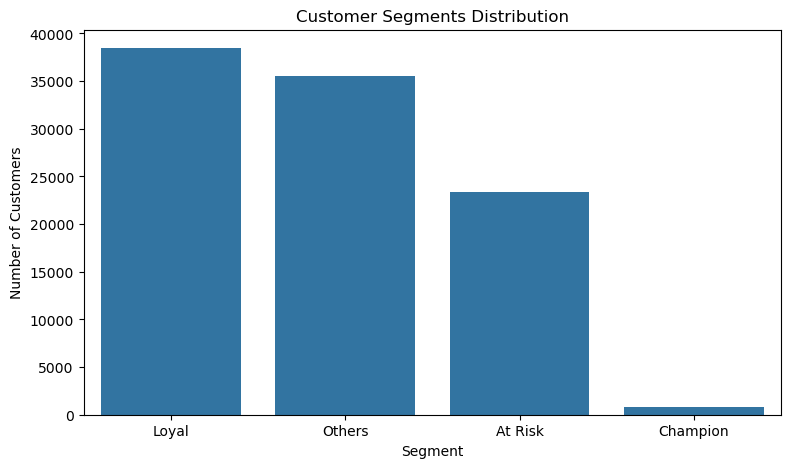

In [24]:
plt.figure(figsize=(9,5))
sns.countplot(x='Segment', data=rfm, order=rfm['Segment'].value_counts().index)
plt.title('Customer Segments Distribution')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.show()

The majority of customers fall into the **Loyal (~38K)** and **Others (~35K)** segments, indicating moderate engagement across the customer base.  

A substantial portion (~23K) are classified as **At Risk**, suggesting potential churn and the need for retention strategies.  

Only a small fraction (~1K) qualify as **Champions**, highlighting a limited pool of highly engaged, high-value customers.